## Solutions to Task 2

> From our server logs, you can access the raw session data, that contains information about single visits to our website (= sessions). A clickout is logged whenever a user clicks on a hotel and is redirected to the booking page. The booking field is binary and indicates if a hotel booking was logged after one of the clickouts. Have a look at the data and check if there is any connection between the booking data and other given information. Feel free to formulate hypothesis based on your findings.


In [151]:
#Imports
import IPython
import numpy as np
import scipy as ap
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sl
import requests as rs
import networkx as nx
#import BeautifulSoup as bs
import mrjob as mj
#import pattern as p
import random
from importlib import reload
import seaborn as sns
import pandasql as ps

In [152]:
# reading the csv file 
url = "/Users/niveda.sridhar/Documents/triv/session_data.csv"
df = pd.read_csv(url, sep=';')
print (df.head(),"\n")
print(df.dtypes,"\n")
print(df.shape)

          session session_start_text session_end_text  clickouts  booking
0  20170503000001           06:11:53         06:15:11          3        0
1  20170503000002           21:06:41         21:08:23          3        0
2  20170503000003           12:03:01         12:06:02          3        0
3  20170503000004           05:58:00         06:02:56          0        0
4  20170503000005           09:13:43         09:17:01          1        0 

session                int64
session_start_text    object
session_end_text      object
clickouts              int64
booking                int64
dtype: object 

(10000, 5)


In [153]:
# adding online duration column
df1=df
df1["online_time"] = pd.to_datetime(df1.session_end_text) - pd.to_datetime(df1.session_start_text)
df1.head()

,session,session_start_text,session_end_text,clickouts,booking,online_time
0,20170503000001,06:11:53,06:15:11,3,0,00:03:18
1,20170503000002,21:06:41,21:08:23,3,0,00:01:42
2,20170503000003,12:03:01,12:06:02,3,0,00:03:01
3,20170503000004,05:58:00,06:02:56,0,0,00:04:56
4,20170503000005,09:13:43,09:17:01,1,0,00:03:18


In [154]:
print (max(df1.online_time))
print (min(df1.online_time))

print (max(df1.clickouts))
print (min(df1.clickouts))


0 days 00:06:18
-1 days +00:01:39
8
0


In [155]:
df1['num'] = df1['online_time'].dt.total_seconds().div(60).astype(float)
df1['mins'] = df1['online_time'].dt.total_seconds().div(60).astype(int)
print (df1.head())
df1.dtypes

          session session_start_text session_end_text  clickouts  booking  \
0  20170503000001           06:11:53         06:15:11          3        0   
1  20170503000002           21:06:41         21:08:23          3        0   
2  20170503000003           12:03:01         12:06:02          3        0   
3  20170503000004           05:58:00         06:02:56          0        0   
4  20170503000005           09:13:43         09:17:01          1        0   

  online_time       num  mins  
0    00:03:18  3.300000     3  
1    00:01:42  1.700000     1  
2    00:03:01  3.016667     3  
3    00:04:56  4.933333     4  
4    00:03:18  3.300000     3  


session                         int64
session_start_text             object
session_end_text               object
clickouts                       int64
booking                         int64
online_time           timedelta64[ns]
num                           float64
mins                            int64
dtype: object

In [156]:
# basic groupby by averaging: basic descriptive analysis

d_temp = df1.groupby('booking').mean().reset_index()
d_temp

# clickouts is a poor indicator of bookings.
# the average minutes user has spent on the platform is considerably more for those who booked a room
# Goes to say that the more time spent the more likely that the user will book the room

,booking,session,clickouts,num,mins
0,0,2.017050e+13,2.502491,0.946459,0.453559
1,1,2.017050e+13,2.323681,3.055377,2.588418


In [157]:
# can be the median! 
d_temp2 = df1.groupby('booking').median().reset_index()
d_temp2

,booking,session,clickouts,num,mins
0,0,20170503004995,2,3.016667,3
1,1,20170503005010,2,3.150000,3


    mins  session  session_start_text  session_end_text  clickouts  booking  \
0  -1438        4                   4                 4          4        4   
1  -1437        4                   4                 4          4        4   
2  -1436        4                   4                 4          4        4   
3  -1434        1                   1                 1          1        1   
4      0      252                 252               252        252      252   
5      1     1347                1347              1347       1347     1347   
6      2     3225                3225              3225       3225     3225   
7      3     3460                3460              3460       3460     3460   
8      4     1428                1428              1428       1428     1428   
9      5      261                 261               261        261      261   
10     6       14                  14                14         14       14   

    online_time   num  
0             4     4  
1  

(array([2.930e+02, 1.352e+03, 3.441e+03, 3.293e+03, 0.000e+00, 1.380e+03,
        2.290e+02, 1.100e+01, 0.000e+00, 1.000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

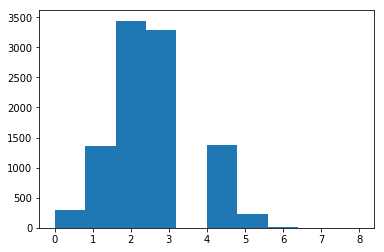

In [158]:
# there are negative mins! --> uncleaned data !!!  13 such entries!
d_temp3 = df1.groupby('mins').count().reset_index()
print(d_temp3)
plt.hist(df1.clickouts)

# looks more or less normally distributed

(array([9033.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         967.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

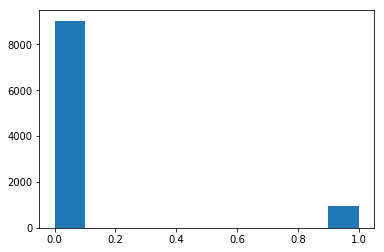

In [159]:
plt.hist(df1.booking)

/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named
/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


   mins   cs
0     1   86
1     2  280
2     3  341
3     4  157
4     5   40
5     6    1 

   mins    cs
0     1  1261
1     2  2945
2     3  3119
3     4  1271
4     5   221
5     6    13 

0    0.068200
1    0.095076
2    0.109330
3    0.123525
4    0.180995
5    0.076923
Name: cs, dtype: float64


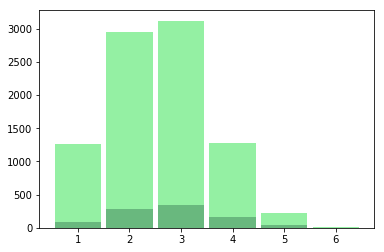

In [160]:
# Analysis based on the time spent on the platform
a = ("""select distinct mins, count(session) as cs from df1 where booking = 1 and mins > 0 group by 1""" )
aa = ps.sqldf(a, locals())
print (aa, "\n")

a1 = ("""select mins, count(session) as cs from df1 where booking = 0 and mins > 0 group by 1""" )
aa1 = ps.sqldf(a1, locals())
print(aa1, "\n")

#ratio
aa2 = aa.cs/aa1.cs
print(aa2)

# The ratio looks very similar

barWidth = 0.9

plt.bar(aa.mins, aa.cs, width = barWidth, color = (0.3,0.1,0.4,0.6))
plt.bar(aa1.mins, aa1.cs, width = barWidth, color = (0.3,0.9,0.4,0.6))

plt.show()

/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named
/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


   clickouts   cs
0          0   23
1          1  129
2          2  338
3          3  277
4          4  118
5          5   19
6          6    1 

   clickouts    cs
0          0   207
1          1  1196
2          2  3034
3          3  2937
4          4  1239
5          5   206
6          6    10
7          8     1 

0    0.068200
1    0.095076
2    0.109330
3    0.123525
4    0.180995
5    0.076923
Name: cs, dtype: float64


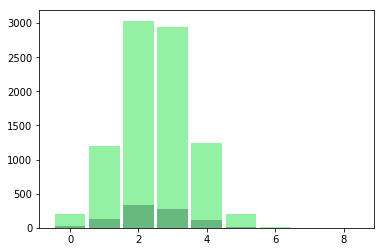

In [161]:
# Analysis based on the clickouts made by the user
b = ("""select clickouts, count(session) as cs from df1 where booking = 1 and mins > 0 group by 1""" )
bb = ps.sqldf(b, locals())
print(bb, "\n")

# n two clikouts have all the 

b1 = ("""select clickouts, count(session) as cs from df1 where booking = 0 and mins > 0 group by 1""" )
bb1 = ps.sqldf(b1, locals())
print(bb1,"\n")

#ratio
bb2 = bb.cs/bb1.cs
print(aa2)

# The ratio looks very similar

barWidth = 0.9

plt.bar(bb.clickouts, bb.cs, width = barWidth, color = (0.3,0.1,0.4,0.6))
plt.bar(bb1.clickouts, bb1.cs, width = barWidth, color = (0.3,0.9,0.4,0.6))

plt.show()

/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


weights: 
[-0.01475661  0.00368841] 

Intercept: 
0.0967 

R square value: 
0.0026369365916882877 



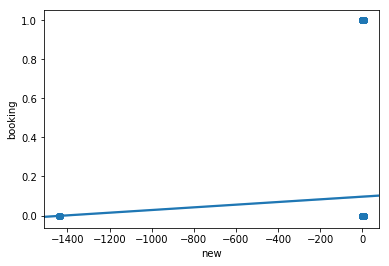

In [49]:
# another approach that may help :: multivariable linear regression
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression

X,Y= scale (df1[['clickouts','num']]), df1['booking']

#df[['A', 'B']]

linReg = LinearRegression(normalize = True)
linReg.fit(X,Y)
print('weights: ')
print(linReg.coef_,"\n")
print('Intercept: ')
print(linReg.intercept_,"\n")

#linReg.fig(X,y)
print('R square value: ')
print( linReg.score(X,Y),"\n")


sns.regplot(x="num", y="booking", data=df1)

# the resulting R^2 value is too low thus it explains very little. 
# Not the best approach
# Logistic regression may further help

## Rough work

/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


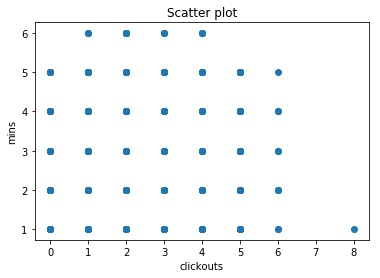

In [98]:
g11 = ("""select clickouts, mins from df1 where booking = 0 and mins > 0""" )
g1 = ps.sqldf(g11, locals())
g11 = ("""select clickouts, mins from df1 where booking = 0 and mins > 0""" )
g1 = ps.sqldf(g11, locals())
plt.scatter(g1.clickouts, g1.mins)
plt.title('Scatter plot')
plt.xlabel('clickouts')
plt.ylabel('mins')
plt.show()

/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


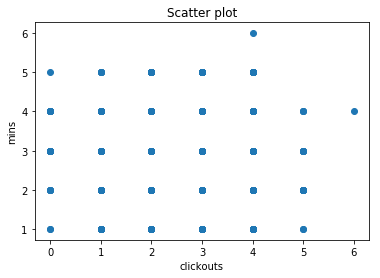

In [99]:
g11 = ("""select clickouts, mins from df1 where booking = 1 and mins > 0""" )
g1 = ps.sqldf(g11, locals())

plt.scatter(g1.clickouts, g1.mins)
plt.title('Scatter plot')
plt.xlabel('clickouts')
plt.ylabel('mins')
plt.show()

/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named
/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


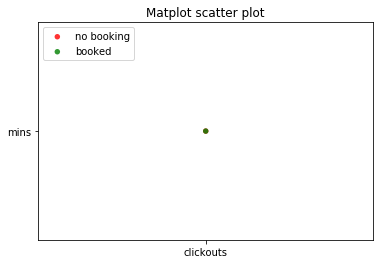

In [96]:
g11 = ("""select clickouts, mins from df1 where booking = 0 and mins > 0""" )
g1 = ps.sqldf(g11, locals())

g12 = ("""select clickouts, mins from df1 where booking = 1 and mins > 0""" )
g2 = ps.sqldf(g12, locals())


data = (g1, g2)
colors = ("red", "green")
groups = ("no booking", "booked")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")

for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Matplot scatter plot')
plt.legend(loc=2)
plt.show()


/Users/niveda.sridhar/anaconda3/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


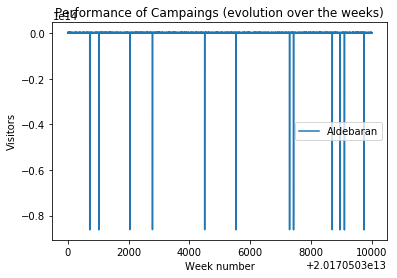

In [9]:
sql7 = ("""select session, online_time from df1 """ )
#print(ps.sqldf(sql7, locals()))
dfa = ps.sqldf(sql7, locals())


plt.title("Performance of Campaings (evolution over the weeks)")
plt.xlabel('Week number')
plt.ylabel('Visitors')
plt.plot(dfa.session, dfa.online_time, label='Aldebaran')

plt.legend()
plt.show()
